In [1]:
#import os

#apt-get -qq update; apt-get install -y python-dev libfftw3-dev libeigen3-dev ffmpeg pybind11-dev
#pip install rmjarvis.eigency>=1.77.1
#pip install galsim --no-cache-dir
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import galsim 
import scipy as sp

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd drive/MyDrive/denoising

In [3]:
import itertools
np.random.seed(seed=10)

# Define the ellipticities for each stars (e1s and e2s), 
# and the constant shape of the stars before the shearing (sigma, fwhm_psf)
e1 = np.linspace(-0.15, 0.15, num=15, endpoint=True)
e2 = np.linspace(-0.15, 0.15, num=15, endpoint=True)
R2 = np.random.uniform(2.5, 8, 10)
sigma = np.sqrt(R2/2)
fwhm_psf = (2*np.sqrt(2*np.log(2)))*sigma
SNR = np.linspace(10, 200, 19, dtype=int)
SNR = np.append(SNR, 0)

es = list(itertools.product(*[e1, e2, fwhm_psf, SNR]))
e1s = np.array([a for a,b,c,d in es])
e2s = np.array([b for a,b,c,d in es]) 
fwhms = np.array([c for a,b,c,d in es])
snr = np.array([d for a,b,c,d in es])

# Generate the 1000 combinations of e1, e2 and fwhm

################################################################################################################

# Define the ellipticities for each stars (e1s and e2s), 
# and the constant shape of the stars before the shearing (sigma, fwhm_psf)
#e1 = np.linspace(-0.13, 0.13, num=15, endpoint=True)
#e1[1]=-0.13
#e1[4]=-0.07
#e1[9]=0.01
#e1[11]=0.09
#e2 = np.linspace(-0.13, 0.13, num=15, endpoint=True)
#e2[1]=-0.13
#e2[4]=-0.07
#e2[9]=0.01
#e2[11]=0.09
#R2 = np.linspace(2.5, 8, 10)
#sigma = np.sqrt(R2/2)
#fwhm_psf = (2*np.sqrt(2*np.log(2)))*sigma
#SNR = [20, 42, 52, 83, 105, 115, 126, 147, 168, 178, 180]

#es = list(itertools.product(*[e1, e2, fwhm_psf, SNR]))
#e1s = np.array([a for a,b,c,d in es])
#e2s = np.array([b for a,b,c,d in es]) 
#fwhms = np.array([c for a,b,c,d in es])
#snr = np.array([d for a,b,c,d in es])


## Ou alors garder un nombre d'images à 25 000 et faire n bins dedans

################################################################################################################

#e1 = np.array([-0.15, -0.11142857, -0.05571429, 0.03714286, 0.07428571, 0.15])
#e2 = np.array([-0.15, -0.11142857, -0.05571429, 0.03714286, 0.07428571, 0.15])
#R2 = np.linspace(2.5, 8, 10)
#sigma = np.sqrt(R2/2)
#fwhm_psf = (2*np.sqrt(2*np.log(2)))*sigma
#SNR = [10, 20, 31, 65, 136, 157, 190, 0]

#es = list(itertools.product(*[e1, e2, fwhm_psf, SNR]))
#e1s = np.array([a for a,b,c,d in es])
#e2s = np.array([b for a,b,c,d in es]) 
#fwhms = np.array([c for a,b,c,d in es])
#snr = np.array([d for a,b,c,d in es])

In [4]:
# Parameters
image_size = 51
psf_flux = 1.
beta_psf =  4.8 # 4.8# 2.5
pix_scale = 0.187
#desired_SNR = 30

# Generate the vignets
new_vignets_noiseless = np.zeros((e1s.shape[0],image_size,image_size))
new_vignets_with_noise = np.zeros((e1s.shape[0],image_size,image_size))
new_e1_HSM = np.zeros(e1s.shape)
new_e2_HSM = np.zeros(e1s.shape)
new_R2_HSM = np.zeros(e1s.shape)
for it in range(e1s.shape[0]):
    
    # PSF generation. Define size
    psf = galsim.Moffat(fwhm=fwhms[it]*pix_scale, beta=beta_psf)
#     psf = galsim.Gaussian(fwhm=fwhms[it]*pix_scale)#, beta=beta_psf)
    # Define the Flux
    psf = psf.withFlux(psf_flux)
    # Define the shear
    psf = psf.shear(g1=e1s[it], g2=e2s[it])
    # Draw the PSF on a vignet
    noisy_image_epsf = galsim.ImageF(image_size, image_size)
    # Define intrapixel shift (uniform distribution in [-0.5,0.5])
    rand_shift = np.random.rand(2)-0.5
    psf.drawImage(image=noisy_image_epsf, offset=rand_shift, scale=pix_scale)

    sigma_noise = np.sqrt((np.sum(noisy_image_epsf.array**2))/(snr[it] * image_size**2))
    # Generate Gaussian noise for the PSF 
    gaussian_noise = galsim.GaussianNoise(sigma=sigma_noise)
    
    # Before adding the noise, we measure the ellipticity components
#     my_moments = noisy_image_epsf.FindAdaptiveMom()
    my_moments = galsim.hsm.FindAdaptiveMom(noisy_image_epsf)
    new_e1_HSM[it] = my_moments.observed_shape.g1
    new_e2_HSM[it] = my_moments.observed_shape.g2
    new_R2_HSM[it] = my_moments.moments_sigma

    # Save images before adding the noise

    new_vignets_noiseless[it,:,:] = noisy_image_epsf.array
    
    # Add Gaussian noise to the PSF 
    
    if snr[it]>0:
      noisy_image_epsf.addNoise(gaussian_noise)
      new_vignets_with_noise[it,:,:] = noisy_image_epsf.array
    else:
      new_vignets_with_noise[it,:,:] = noisy_image_epsf.array
    

<ipython-input-4-e8d877443354>:29: RuntimeWarning: divide by zero encountered in true_divide
  sigma_noise = np.sqrt((np.sum(noisy_image_epsf.array**2))/(snr[it] * image_size**2))


In [5]:
train_dic = {'VIGNET_NOISELESS':new_vignets_noiseless,'VIGNETS_WITH_NOISE':new_vignets_with_noise,  
             'TRUE_E1_HSM':new_e1_HSM,'TRUE_E2_HSM':new_e2_HSM,'TRUE_R2_HSM':new_R2_HSM}



First star's ellipticity is: (-0.14649272480024125,-0.14651650226459972)
Second star's ellipticity is: (-0.14213120533056228,-0.0610222519112723)


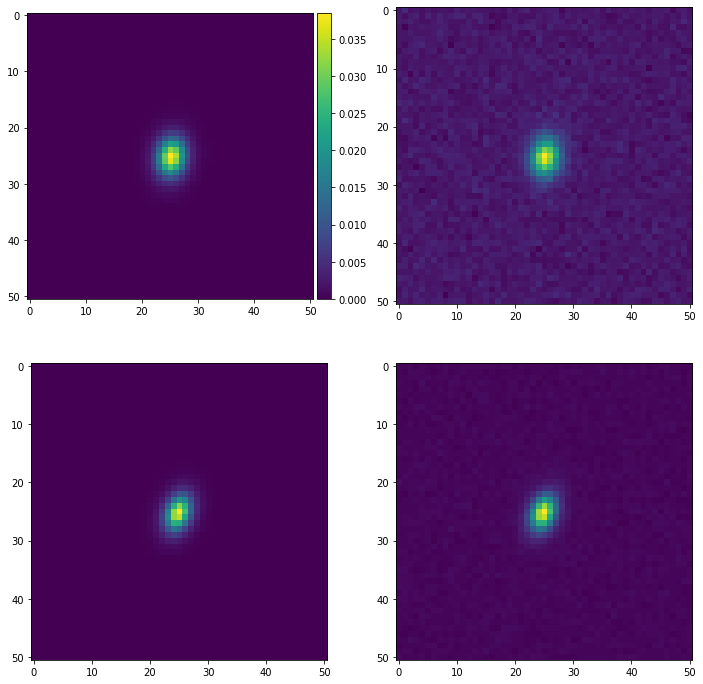

In [6]:
one_star_noiseless = new_vignets_noiseless[1000,:,:]
one_star_noise = new_vignets_with_noise[1000,:,:]
second_star_noiseless = new_vignets_noiseless[288,:,:]
second_star_noise = new_vignets_with_noise[288,:,:]

fig = plt.figure(num=0, figsize=(12,12))
ax1 = fig.add_subplot(2,2,1)
im1 = ax1.imshow(one_star_noiseless, interpolation='None')
ax2 = fig.add_subplot(2,2,2)
im2 = ax2.imshow(one_star_noise, interpolation='None')
ax3 = fig.add_subplot(2,2,3)
im3 = ax3.imshow(second_star_noiseless, interpolation='None')
ax4 = fig.add_subplot(2,2,4)
im4 = ax4.imshow(second_star_noise, interpolation='None')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

print("First star's ellipticity is: ({},{})".format(new_e1_HSM[0], new_e2_HSM[0]))
print("Second star's ellipticity is: ({},{})".format(new_e1_HSM[999], new_e2_HSM[999]))

In [10]:
np.save('datasets/dataset_45_61.npy', train_dic, allow_pickle=True)

In [9]:
len(train_dic['VIGNET_NOISELESS'])

45000